In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torchvision
import torchvision.transforms as transforms
import cv2
from PIL import Image
import random

In [2]:
#set this to True if you want to train the model.
Train = False
#Train = True

In [3]:
if Train == True :
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [4]:
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)

In [5]:
class MyDataset(Dataset):
    
    def __init__(self, image_paths, target_paths,train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.files = os.listdir(self.image_paths)
        self.lables = os.listdir(self.target_paths)
    
    def transform(self, image, mask):
            
        # Random crop
        if random.random() > 0.5:
            affine_params=transforms.RandomAffine(180).get_params((-90, 90), (0.1,0.1), (0.8, 1.2), None, image.size)
            image = TF.affine(image, *affine_params)
            mask = TF.affine(mask, *affine_params)    

        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        
        # Normalize the image
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        image = norm(image)
        
        return image, mask

    def __getitem__(self, idx):
        img_name = self.files[idx]
        label_name = self.lables[idx]
        
        image = Image.open(os.path.join(self.image_paths,img_name))
        mask = Image.open(os.path.join(self.target_paths,label_name))        
       
        x, y= self.transform(image,mask)
        return x, y
     
    def __len__(self):
        
        return len(self.files)

In [6]:
image_path = 'Trainset3/Image'
label_paht = 'Trainset3/Label'
dataset = MyDataset(image_path,label_paht)

In [7]:
len(dataset) #just check the number of images on the dataset

5024

In [8]:
#you can change the batch_size here
#for the batch_size, the smaller tends to be better.
#dataloader = DataLoader(dataset=dataset, batch_size=8, shuffle=True, pin_memory=True)

In [9]:
train_length=int(0.90* len(dataset))
test_length=len(dataset)-train_length
train_dataset,val_dataset = torch.utils.data.random_split(dataset, (train_length,test_length))

In [10]:
trainloader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True, pin_memory=True)
valloader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=True, pin_memory=True)

In [5]:
#model structure thanks to https://github.com/mateuszbuda/brain-segmentation-pytorch
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, features=32):
        super(UNet, self).__init__()
        def conv_block(in_channels, features):
            return nn.Sequential(
                nn.Conv2d(in_channels, features, kernel_size=3, padding=1),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True),
                nn.Conv2d(features, features, kernel_size=3, padding=1),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True),
                #nn.Dropout(p=0.2)
                #nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.enc1 = conv_block(in_channels,features)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc2 = conv_block(features,features*2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc3 = conv_block(features*2,features*4)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc4 = conv_block(features*4,features*8)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(features*8,features*16)
        
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.dec4 = conv_block((features * 8) * 2, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.dec3 = conv_block((features * 4) * 2, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.dec2 = conv_block((features * 2) * 2, features*2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.dec1 = conv_block(features * 2, features)
        self.out = nn.Conv2d(features, out_channels, kernel_size=1)
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.maxpool1(e1))
        e3 = self.enc3(self.maxpool2(e2))
        e4 = self.enc4(self.maxpool3(e3))
        #e4 = torch.nn.functional.dropout(e4,p=0.3)
        bottleneck = self.bottleneck(self.maxpool4(e4))
        
        d4 = self.upconv4(bottleneck)
        d4 = torch.cat((d4,e4), dim=1)
        d4 = self.dec4(d4)
        #d4 = torch.nn.functional.dropout(d4,p=0.2)
        d3 = self.upconv3(d4)
        d3 = torch.cat((d3,e3), dim=1)
        d3 = self.dec3(d3)
        #d3 = torch.nn.functional.dropout(d3,p=0.2)
        d2 = self.upconv2(d3)
        d2 = torch.cat((d2,e2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat((d1,e1), dim=1)
        d1 = self.dec1(d1)
        output = self.out(d1)
        #output = torch.sigmoid(output) #sigmoid as a last activation layer.
        #no need sigmoid if use BCEwithlogitloss
        return output

In [12]:
unet = UNet()
unet = unet.to(device)

In [13]:
def dice_score(pred, target,smooth=1):
    
  
    pred = torch.sigmoid(pred)
    if target.sum().item() == 0:
        pred = (pred>0.5).float()
    N = target.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = target.view(N, -1)
 
    intersection = (pred_flat * gt_flat).sum(1)
    #unionset = pred_flat.sum(1) + gt_flat.sum(1)
    unionset = (pred_flat ** 2).sum(1) + (gt_flat ** 2).sum(1)
    loss = ((2. * (intersection)) + smooth) / (unionset + smooth)
    return loss.sum() / N
    
''' initialize an empty list when Scores is called, append the list with dice scores
for every batch, at the end of epoch calculates mean of the dice scores'''
class Scores:
    def __init__(self, phase, epoch):
        self.base_dice_scores = []

    def update(self, targets, outputs):
        probs = outputs
        dice= dice_score(probs, targets)
        self.base_dice_scores.append(dice.item())

    def get_metrics(self): 
        dice = sum(self.base_dice_scores)/len(self.base_dice_scores)
        return dice

'''return dice score for epoch when called'''
def epoch_log(phase, epoch_loss, measure):
    '''logging the metrics at the end of an epoch'''
    dices= measure.get_metrics()                          
    print("%s: Loss: %0.4f |dice: %0.4f" % (phase, epoch_loss, dices))
    return dices


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'
 
    def __init__(self):
        super(DiceLoss, self).__init__()

 
    def forward(self, pred, target):
        return 1 - dice_score(pred, target)

In [14]:
#train
if Train == True:
    
    optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75,125], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,70], gamma=0.1)
    #criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(19.))
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.))
    criterion_val = torch.nn.BCEWithLogitsLoss()
    #criterion = DiceLoss().to(device)
    n_epochs = 85
    epoch_train_loss = []
    epoch_train_dice = []
    epoch_val_loss = []
    epoch_val_dice = []
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        train_score=Scores('Train',epoch)
        val_score=Scores('Validation',epoch)
        loss_train_avg = 0
        loss_val_avg = 0
        unet.train()
        print('epoch' + str(epoch))
        for i, data in enumerate(trainloader,0):
            optimizer.zero_grad()
            img,mask = data
            img = img.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            output = unet(img)
            train_score.update(mask,output)
            train_loss = criterion(output,mask)
            train_loss.backward()
            optimizer.step()
            loss_train_avg = loss_train_avg+train_loss.item()
        
        with torch.no_grad():
            unet.eval()
            for i, data in enumerate(valloader,0):
                optimizer.zero_grad()
                img,mask = data
                img = img.to(device, dtype=torch.float)
                mask = mask.to(device, dtype=torch.float)
                output = unet(img)
                val_score.update(mask,output)
                val_loss = criterion_val(output,mask)
                loss_val_avg = loss_val_avg+val_loss.item()
            
        
            
        loss_ep_train = loss_train_avg/len(trainloader)
        dice_train = epoch_log('Train',loss_ep_train, train_score)
        epoch_train_loss.append(loss_ep_train)
        epoch_train_dice.append(dice_train)
        
        loss_ep_val = loss_val_avg/len(valloader)
        dice_val = epoch_log('Validation',loss_ep_val, val_score)
        epoch_val_loss.append(loss_ep_val)
        epoch_val_dice.append(dice_val)
        
        scheduler.step()
        '''
        if loss_ep_val < best_val_loss:
            print("******** New optimal found, saving state ********")
            best_val_loss = loss_ep_val
            state = {
                "state_dict": unet.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            torch.save(state, 'unet_tf_1.pth')
        '''
        

epoch0
Train: Loss: 0.3749 |dice: 0.2419
Validation: Loss: 0.1256 |dice: 0.2796
epoch1
Train: Loss: 0.2799 |dice: 0.3553
Validation: Loss: 0.1355 |dice: 0.3612
epoch2
Train: Loss: 0.2429 |dice: 0.3992
Validation: Loss: 0.1054 |dice: 0.3979
epoch3
Train: Loss: 0.2295 |dice: 0.4185
Validation: Loss: 0.1166 |dice: 0.3992
epoch4
Train: Loss: 0.2197 |dice: 0.4304
Validation: Loss: 0.1392 |dice: 0.3699
epoch5
Train: Loss: 0.2147 |dice: 0.4359
Validation: Loss: 0.0908 |dice: 0.4239
epoch6
Train: Loss: 0.2101 |dice: 0.4404
Validation: Loss: 0.1368 |dice: 0.3891
epoch7
Train: Loss: 0.2068 |dice: 0.4464
Validation: Loss: 0.1255 |dice: 0.4037
epoch8
Train: Loss: 0.2042 |dice: 0.4495
Validation: Loss: 0.1020 |dice: 0.4264
epoch9
Train: Loss: 0.2014 |dice: 0.4538
Validation: Loss: 0.0952 |dice: 0.4370
epoch10
Train: Loss: 0.1903 |dice: 0.4669
Validation: Loss: 0.1007 |dice: 0.4385
epoch11
Train: Loss: 0.1880 |dice: 0.4698
Validation: Loss: 0.0914 |dice: 0.4525
epoch12
Train: Loss: 0.1871 |dice: 0.4

In [15]:
if Train == True:
    np.save('train_epoch_loss_tf_1', epoch_train_loss)
    np.save('train_epoch_dice_tf_1', epoch_train_dice)
    np.save('val_epoch_loss_tf_1', epoch_val_loss)
    np.save('val_epoch_dice_tf_1', epoch_val_dice)

In [6]:
if Train == True:
    state = {
                "state_dict": unet.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
    torch.save(state, 'unet_tf_1.pth')
else:
    unet = UNet()
    model = torch.load('unet_tf_1.pth', map_location=torch.device('cpu'))
    unet.load_state_dict(model['state_dict'])
    unet.to(device)
    unet.eval()

In [7]:
def dice_test(pred, target,smooth=1e-5):
    pred = torch.sigmoid(pred)
    intersection = (pred*target).sum()
    union = (pred ** 2).sum() + (target ** 2).sum()
    return (((2. * intersection)+smooth)/(union+smooth)).item()

In [14]:
def dice_test2(pred, target,smooth=1):
    pred = torch.sigmoid(pred)
    N = target.size(0)
    pred_flat = pred.view(N, -1)
    gt_flat = target.view(N, -1)
    if target.sum().item() == 0:
        pred = (pred>0.5).float()
    pred = (pred>0.3).float()
    intersection = (pred_flat * gt_flat).sum(1)
    unionset = (pred_flat ** 2).sum(1) + (gt_flat ** 2).sum(1)
    loss = ((2. * (intersection)) + smooth) / (unionset + smooth)
    return loss.sum() / N

In [9]:
TEST_PATH = 'Trainset2/Test/60.PNG' #path to the image that we want to test
TEST_Label = 'Trainset2/Testlabel/60.PNG'
img_input = Image.open(TEST_PATH)
img_input = np.array(img_input)
img_input = TF.to_tensor(img_input).unsqueeze(dim=0)
img_input = img_input.to(device, dtype=torch.float)

In [10]:
output = unet(img_input)
target = Image.open(TEST_Label)
target = np.array(target)
target = TF.to_tensor(target).unsqueeze(dim=0)

In [11]:
dice_test(output.cpu(),target)

0.7734811305999756

In [15]:
dice_test2(output.cpu(),target)

tensor(0.7735, grad_fn=<DivBackward0>)

In [146]:
output = torch.sigmoid(output)
output = (output>0.3).float()
predicted = output[0].squeeze(dim=0)

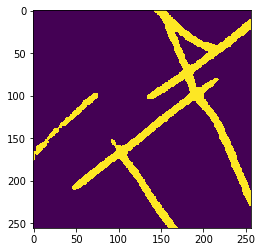

In [147]:
plt.imshow(predicted.cpu().detach().numpy())

In [68]:
predicted_array = predicted.detach().cpu().numpy()
G = np.zeros((256,256,3))
G[predicted_array>0.3] = [1,1,1]
G[predicted_array<0.3] = [0,0,0]

In [ ]:
def predict(model,test_img):
    device = torch.device('cpu')
    with torch.no_grad():
        model.eval()
    img_input = np.array(test_img)
    img_input = TF.to_tensor(img_input).unsqueeze(dim=0)
    img_input = img_input.to(device, dtype=torch.float)
    output = unet(img_input)
    output = torch.sigmoid(output)
    predicted = output[0].squeeze(dim=0)
    predicted_array = predicted.detach().cpu().numpy()
    
    #G = np.zeros((256,256,3))
    #G[predicted_array>-6] = [1,1,1]
    #G[predicted_array<-6] = [0,0,0]
    return predicted_array

In [ ]:
def crop_predict(model,test_img_path):
    test_img = Image.open(test_img_path)
    (width,height)=test_img.size
    size = 256 #size of extracted images
    col = width//size #number of col
    row = height//size #number of row
    #output_img = np.zeros((size*row,size*col,3))
    output_img = np.zeros((size*row,size*col))
    for r in range(row):
            for c in range(col):
                box = (size*c,size*r,size*c+size,size*r+size) #upper left and lower right of the image
                img_crop = test_img.crop(box)
                predict_img = predict(model,img_crop)
                #output_img[size*r:size*r+size,size*c:size*c+size,:]=predict_img
                output_img[size*r:size*r+size,size*c:size*c+size]=predict_img
                
    return output_img
                

In [ ]:
TEST_PATH = 'Trainset2/Test_/BS_1.PNG'
out1 = crop_predict(unet,TEST_PATH )

In [ ]:
plt.imshow(out1,cmap='gray',interpolation='nearest')
plt.imsave('BS_1_result_1_500iter.png',out1,cmap='gray')